In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set(style='white')

In [2]:
df = pd.read_csv('traf_final.csv')
df.head()

,client_id,day,call_in_num,call_out_num,call_in_dur,call_out_dur,sms_out_num,gprs
0,09777552-cc75-4f03-9438-11c3a7480f97,7,0.0,3.0,0.0,418.0,0.0,0.0
1,09777552-cc75-4f03-9438-11c3a7480f97,1,0.0,1.0,0.0,1558.0,0.0,0.0
2,09777552-cc75-4f03-9438-11c3a7480f97,13,0.0,1.0,0.0,52.0,0.0,0.0
3,09777552-cc75-4f03-9438-11c3a7480f97,11,0.0,1.0,0.0,84.0,1.0,0.0
4,09777552-cc75-4f03-9438-11c3a7480f97,3,0.0,2.0,0.0,211.0,4.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3726461 entries, 0 to 3726460
Data columns (total 8 columns):
client_id       object
day             int64
call_in_num     float64
call_out_num    float64
call_in_dur     float64
call_out_dur    float64
sms_out_num     float64
gprs            float64
dtypes: float64(6), int64(1), object(1)
memory usage: 227.4+ MB


In [4]:
df.describe()

,day,call_in_num,call_out_num,call_in_dur,call_out_dur,sms_out_num,gprs
count,3.726461e+06,3.726461e+06,3.726461e+06,3.726461e+06,3.726461e+06,3.726461e+06,3.726461e+06
mean,1.321518e+01,2.773630e+00,6.130744e+00,3.947236e+02,6.969378e+02,1.112852e+00,1.734049e+02
std,8.812369e+00,4.753978e+00,1.065069e+01,9.899626e+02,1.429918e+03,1.456473e+01,8.464323e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.990000e+02,0.000000e+00,0.000000e+00
25%,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.300000e+01,1.000000e+00,3.000000e+00,4.500000e+01,1.260000e+02,0.000000e+00,0.000000e+00
75%,2.100000e+01,4.000000e+00,8.000000e+00,3.620000e+02,7.720000e+02,0.000000e+00,5.715937e+01
max,2.900000e+01,6.100000e+02,1.906000e+03,5.474100e+04,5.863500e+04,4.830000e+03,1.862037e+05


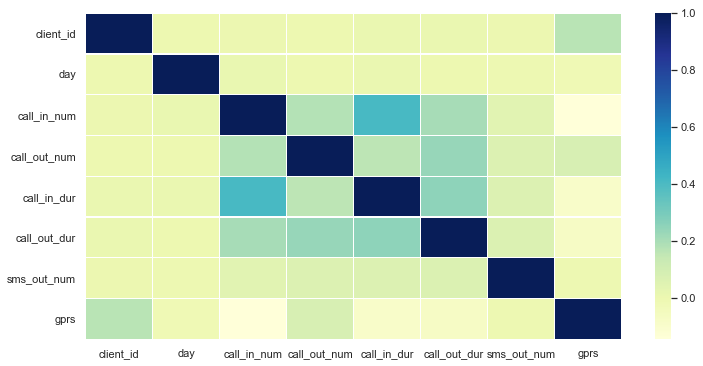

In [6]:
plt.figure(figsize=(12, 6))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

In [14]:
df['client_id'].unique().size

240000

In [27]:
target = pd.read_csv('general_final.csv').groupby(['client_id']).mean()
target['churn'] = target['churn'].astype('int8')
joined = df.set_index('client_id').join(target)

,churn
client_id,
000015c6-94a3-4989-861a-ebd71c848c68,0
00007210-4b79-4845-bdcc-b3621e65e2bf,0
0000a503-c107-4578-9410-be301f142013,0
0000d08d-2a6f-4f84-b660-298678c422f7,1
0000e8f2-3741-4196-8d7f-c19ff7a10453,0


Index(['day', 'call_in_num', 'call_out_num', 'call_in_dur', 'call_out_dur',
       'sms_out_num', 'gprs', 'churn'],
      dtype='object')


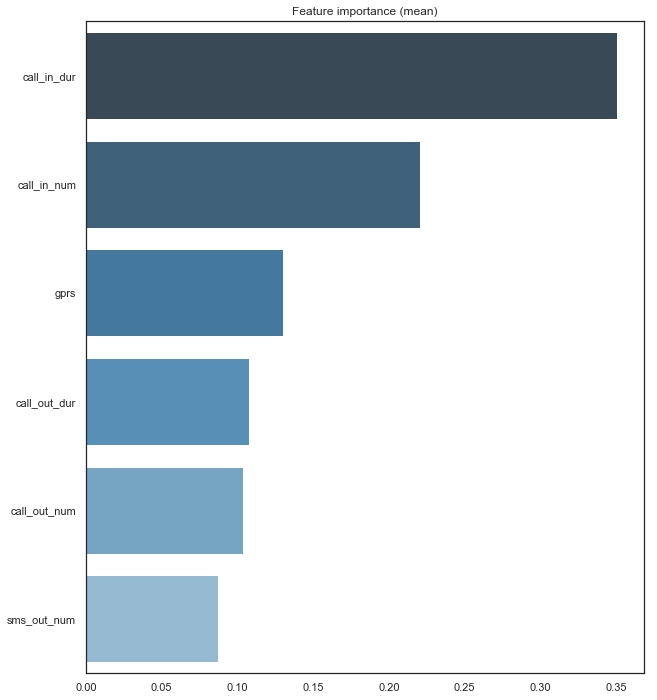

In [109]:
from sklearn.ensemble import RandomForestClassifier
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5, 'max_depth': 8}


clients = joined.groupby(['client_id']).mean()
print(clients.columns)
x, y = clients.drop(['churn', 'day'],axis=1), clients['churn']

clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)

imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance (mean)")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

Index(['day', 'call_in_num', 'call_out_num', 'call_in_dur', 'call_out_dur',
       'sms_out_num', 'gprs', 'churn'],
      dtype='object')


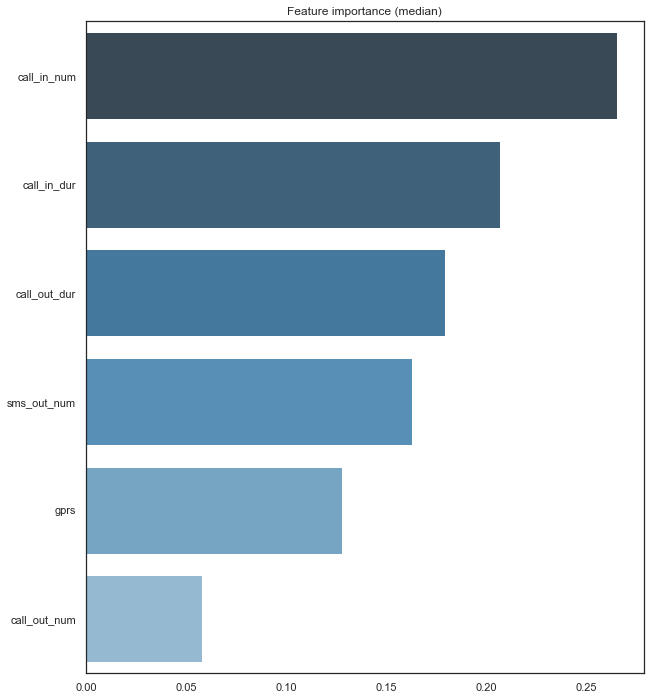

In [110]:
from sklearn.ensemble import RandomForestClassifier
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5, 'max_depth': 8}


clients = joined.groupby(['client_id']).median()
print(clients.columns)
x, y = clients.drop(['churn', 'day'],axis=1), clients['churn']

clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)

imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance (median)")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

In [118]:
def plot_by_features(joined, features):
    days = sorted(joined['day'].unique())
    x0 = joined[joined['churn'] == 0]
    x1 = joined[joined['churn'] == 1]
    
#     x0g = x0.groupby(['day']).mean()
#     x1g = x1.groupby(['day']).mean()

    x0g = x0.groupby(['day']).median()
    x1g = x1.groupby(['day']).median()
#     x0s = x0.groupby(['day']).std()
#     x1s = x1.groupby(['day']).std()

    x02 = x0.groupby(['day']).quantile(q=0.25)
    x12 = x1.groupby(['day']).quantile(q=0.25)
    
    x07 = x0.groupby(['day']).quantile(q=0.75)
    x17 = x1.groupby(['day']).quantile(q=0.75)
    
#         plot it!
    fig, axx = plt.subplots(round(len(features) / 2), 2, figsize=(18,15))
    axx = axx.reshape((-1,))
    for feature, ax in zip(features, axx):
        ax.plot(days, x0g[feature], lw=2, label='churn = 0', color='blue')
        ax.plot(days, x1g[feature], lw=2, label='churn = 1', color='red')
        ax.fill_between(days, x02[feature], x07[feature], facecolor='blue', alpha=0.5)
        ax.fill_between(days, x12[feature], x17[feature], facecolor='red', alpha=0.5)
        ax.set_title(feature + r' and $\pm \sigma$ interval')
        ax.legend(loc='upper left')
        ax.set_xlabel('days')
        ax.set_ylabel(feature)
        ax.grid()


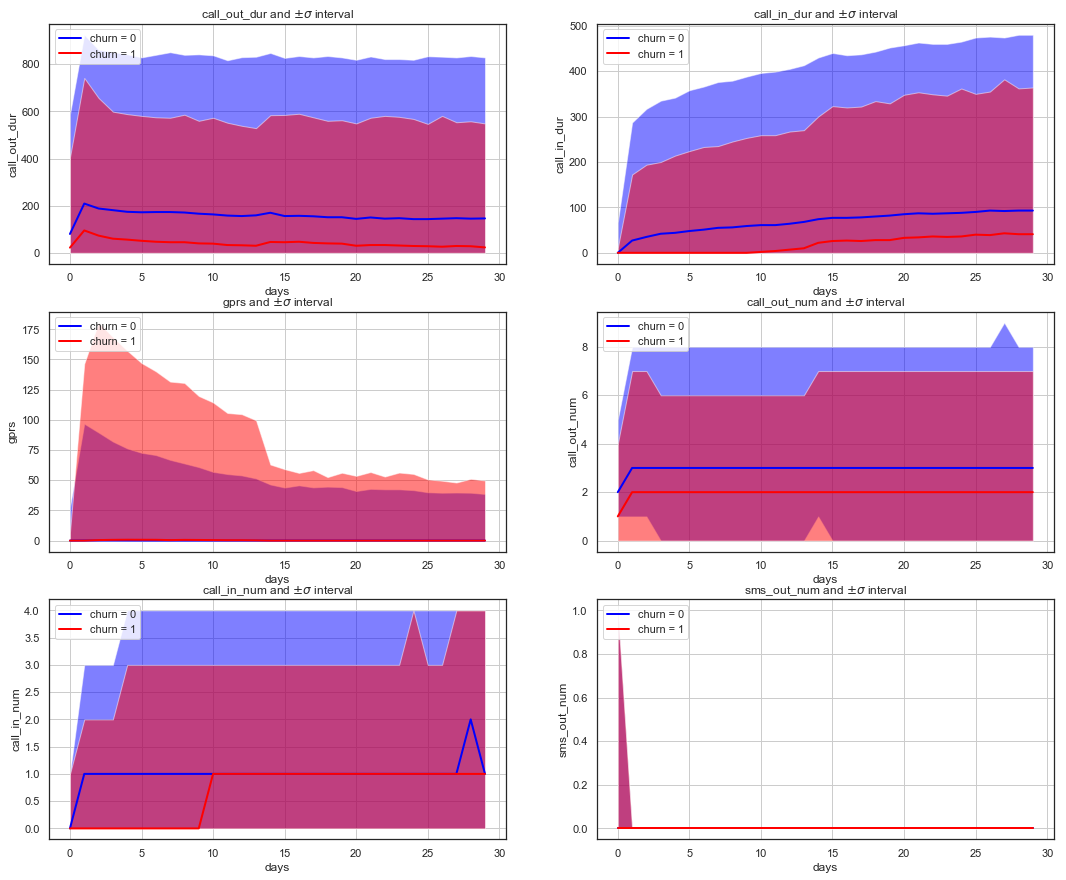

In [119]:
plot_by_features(joined, ['call_out_dur', 'call_in_dur', 'gprs', 'call_out_num', 'call_in_num', 'sms_out_num'])